# ADA Project
<br><br>

----
### Subject: 
finding what influence the number of protests among: area of the country, population density, net migration, infant mortality, deathrate, income group, climate, etc.  
<br><br>

----
### Objective: 
finding what to change in a country to decrease the number of protests (assuming that a less number of protests means that the inhabitants are happier)
<br><br>

----
### Summary:
First, we will get all the data we need. Second we will find a way to display data on a world map to visualize the number of protests around the world. Then, we will try to find the impact of many variables on this number of protests.
<br><br>

----
### Data explanations:
Please see the read me, section Dataset / 4- Data description to see data explanations

Here a brief explanation:

We are using the data available at the following link: https://bigquery.cloud.google.com/table/gdelt-bq:gdeltv2.events This is a context of **big data**: around **400 000 000** of rows.
<br><br>
- ##### <u>eventcodes.csv</u>

As we are interested in protest as kind of event, we need to find the event code associated to the protest events: **eventcodes.csv** gives us this data.
<br><br>
- ##### <u>country_by_income.csv and countries_stats.csv</u>

Then, we need to get data on all the countries to find the impact of their characteristics on the number of protests: **country_by_income.csv** and **countries_stats.csv** give us what we need. Thanks to these files, we have access to: the average income, area of the country, population density, net migration, infant mortality, deathrate, climate, etc of each country.
Got from: http://datatopics.worldbank.org/world-development-indicators/the-world-by-income-and-region.html and https://www.kaggle.com/fernandol/countries-of-the-world/version/1

<br><br>
Let's see the **countries_stats.csv** file:

data got from: https://www.kaggle.com/fernandol/countries-of-the-world/version/1

Data available: `Country`, `Region`, `Population`, `Area (sq. mi.)`, `Pop. Density (per sq. mi.)`, `Coastline (coast/area ratio)`, `Net migration`, `Infant mortality (per 1000 births)`, `GDP ($ per capita)`, `Literacy (%)`, `Phones (per 1000)`, `Arable (%)`, `Crops (%)`, `Other (%)`, `Climate`, `Birthrate`, `Deathrate`, `Agriculture`, `Industry`, `Service`.

Most of the variables don't need to be explain as `population`, `Area (sq. mi.)`, `Infant mortality`, etc. As we wordered the meaning of `climate`, here the explanation we found:

Meaning of `climate`: 1= Dry tropical, 2= Wet tropical, 3= Temperate humid subtropical and temperate continental, 4= Dry hot summers and wet winters
<br><br>
- ##### <u>country_codes_iso2_to_iso3.csv and country_code_to_name.csv</u>

Each data define the country in a different way: code in `ISO2` or `ISO3` or with the `country name`. We need to convert each ones with the same convention. For example, to define the United-States of America, the csv files use "USA", "US" or "United-States of America". 
**country_codes_iso2_to_iso3.csv** and **country_code_to_name.csv** allow us to achieve these conversions.
there are from: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv
<br><br>

- ##### <u>GDP growth world bank.csv and GINI per country worldbank.csv</u> (<a> https://data.worldbank.org </a>)
These two dataset are the estimations of the Gross Domestic Product (GDP) and the Index of Inequality (GINI) for each country , from 1960 to 2017. These datasets will be usefull economical and social indicator to understand the protestation in different countries.
(Higher index is better)

- ##### <u>DataCorruptionPerceptionIndex2000_2017.xlsx</u> (<a>https://www.transparency.org</a>)
This data set shows the estimated Corruption index (political and buisness corruption) for each country from 2000 to 2017. 
(Lower index is better)

- ##### <u>Human Development Index (HDI).csv</u> (<a> http://hdr.undp.org/en/data </a>)
Dataset of the HDI for each country from 1990 to 2017.
HDI a good indicator of the life expectancy and education of people in the country.
The definition of HDI from wikipedia:
"The Human Development Index (HDI) is a statistic composite index of life expectancy, education, and per capita income indicators"
(Higher index is better)



- ##### <u>World press freedom.csv
</u> (<a> https://rsf.org/fr/donnees-classement </a>)(<a> https://en.wikipedia.org/wiki/Press_Freedom_Index </a>)
This data-set shows the score of each country concerning the press freedom from 2002 to 2018
(Lower index is better)



----
### Next steps until Dec. 16
Please see the read me, section "A list of internal milestones until Dec. 16" or the end of the notebook as asked here: https://dlab.epfl.ch/teaching/fall2018/cs401/projects/

In [1]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
import os
import json
import folium
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from sklearn.linear_model import LinearRegression, LogisticRegression
from branca.colormap import linear
import statsmodels.api as sm
from scipy import stats
from functions.folium_functions import folium_map
from functions.dataframe_functions import magnify
import seaborn as sns


DATA_PATH = "data/"

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'C:\\Users\\antho\\Downloads\\ADAproj-02b470a29ee4.json'
# get json by following (Setting up authentication)
# https://cloud.google.com/bigquery/docs/reference/libraries

In [2]:
bigquery_client = bigquery.Client()

# Getting the main tables:

- event codes table
- indication of richness per inhabitant per country
- Protests for leadership change
- Protests for rights
- country codes table
- country codes conversion iso2 to iso3
- statistics on countries

### Event codes:

In [3]:
event_codes = pd.read_csv(DATA_PATH + "eventcodes.csv", encoding = "ISO-8859-1")

### Indication of richness per inhabitant per country per year:

In [4]:
country_by_income_per_year = pd.read_csv(DATA_PATH + "country_by_income.csv", encoding = "ISO-8859-1")

In [5]:
country_by_income_per_year=country_by_income_per_year.dropna()
#here we only get an indicator of the income, we need to transform it to process it
#we choose to transform Low income (L) to 1, (LM) to 3, (UM) to 4, (H) to 6
country_by_income_per_year=country_by_income_per_year.replace('Low income (L)', '-3')
country_by_income_per_year=country_by_income_per_year.replace('Lower middle income (LM)', '-1')
country_by_income_per_year=country_by_income_per_year.replace('Upper middle income (UM)', '1')
country_by_income_per_year=country_by_income_per_year.replace('High income (H)', '3')
country_by_income_per_year['Income Group']=country_by_income_per_year['Income Group'].astype(int)

### Getting all protests events:
With:
- ##### <u> ID </u>
- ##### <u> CountryCode </u>
- ##### <u> EventCode </u>
- ##### <u> Year </u>


In [6]:
reload = False
if os.path.isfile(DATA_PATH + 'protests_df_raw.csv') and ~reload :
    protests_df_raw = pd.read_csv(DATA_PATH + 'protests_df_raw.csv')
else:
    query_protests = bigquery_client.query(
        """SELECT GLOBALEVENTID as ID, ActionGeo_CountryCode as CountryCode,  EventCode, Year FROM `gdelt-bq.gdeltv2.events` 
        WHERE EventCode LIKE '14%' """)
    protests_df_raw = query_protests.result().to_dataframe()
    # Write down the csv
    protests_df_raw.to_csv(DATA_PATH + 'protests_df_raw.csv', index=False)
protests_df = protests_df_raw.dropna()

In [7]:
print("Number of rows we got: " + str(protests_df_raw['CountryCode'].count()))

Number of rows we got: 3746462


### Country codes conversion between :
- fips104,  iso2 and iso3
- iso3 and name:

In [8]:
#Getting conversion between fips104 and iso2 code for countries
country_codes_fips104_to_iso = pd.read_csv(DATA_PATH + "fips104_to_iso.csv", encoding = "ISO-8859-1")

#Getting conversion between iso2 and iso3 code for countries
country_codes_iso2_to_iso3 = pd.read_csv(DATA_PATH + "country_codes_iso2_to_iso3.csv", encoding = "ISO-8859-1")

#merging the two data to convert from Fips 104 to ISO3
country_codes_fips104_to_iso3 = pd.merge(country_codes_fips104_to_iso, country_codes_iso2_to_iso3, how='inner',\
                                         left_on=['ISO 3166'], right_on=['ISO'])[['FIPS 10-4', 'ISO3']]

# Getting conversion between country code and country name
country_codes_to_name = pd.read_csv(DATA_PATH + "country_lat_long.csv", encoding = "ISO-8859-1")

### Getting statistics on countries:

In [9]:
#Getting data about statistics on all the countries
countries_stats = pd.read_csv(DATA_PATH + "countries_stats.csv", encoding = "ISO-8859-1")

In [10]:
#displaying some indicators
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
countries_stats[['Country Name','Area (sq. mi.)','Pop. Density (per sq. mi.)','GDP ($ per capita)','Infant mortality (per 1000 births)','Deathrate']].style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '180px', 'font-size': '8pt'})\
    .set_caption("Hover to magnify")\
    .set_precision(2)\
    .set_table_styles(magnify())


C:\Users\antho\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


# Let's start we our first visualizations:

### Visualizing average income per country on a world map

In [11]:
countries_topodata = json.load(open('data/countries.topojson.json'))

In [12]:
#getting the data from 2017
country_by_income_2017 = country_by_income_per_year[country_by_income_per_year['Year'] == 2017]

In [13]:
#first let's see the result of the income per country
country_by_income_2017[['Country Code','Income Group']].style.bar(subset=['Income Group'], align='mid', color=['#d65f5f', '#5fba7d'])

,Country Code,Income Group
6540,ZWE,-3
6541,ZMB,-1
6542,YEM,-3
6543,PSE,-1
6544,VIR,3
6545,VNM,-1
6546,VEN,1
6547,VUT,-1
6548,UZB,-1
6549,URY,3


As it's hard to visualualize through a dataframe, we will use a map:

In [14]:
#Displaying a map to visualize average income per country in the world
min_value = country_by_income_2017['Income Group'].min()
max_value = country_by_income_2017['Income Group'].max()
colormap = linear.YlGn_09.scale(min_value, max_value)
colormap.caption = 'Income per cap in 2017 (Low = 1, High = 6)'
location=[46.9,8.25]
x = 'Country Code'
y = 'Income Group'

results_map_income = folium_map(country_by_income_2017, x, y, location, countries_topodata, colormap, zoom=1)

results_map_income.save('results_map_income.html')
display(HTML("<h1><a href='results_map_income.html' target='_blank'>results_map_income (Ctrl+Click)</a></h1>"))

results_map_income

Here, thanks to our visualization, we can estimate in which country the inhabitants have a better standard of living. Without any surprise, it's in the North America and in Europe

### Displaying percentage of protests on a world map

In [15]:
#join the protests dataframe to get the iso3 convention for each country
protests_df=pd.merge(protests_df, country_codes_fips104_to_iso3, how='right', left_on=['CountryCode'], right_on=['FIPS 10-4'])

Text(0,0.5,'Countries number')

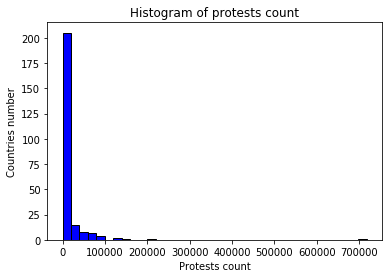

In [16]:
#changing the column name to keep the same naming convention in each dataframe
protests_df=protests_df.rename(index=str, columns={"ISO3": "Country Code"})

#counting the number of protests we have in each country
number_of_protests_per_country = protests_df.groupby(['Country Code']).size().reset_index(name='protests count')

#Getting the distribution of protests count
plt.hist(number_of_protests_per_country['protests count'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of protests count')
plt.xlabel('Protests count')
plt.ylabel('Countries number')


The distribution show that few countries have a very high number of protests. These countries, with a very high number, hids the nuance between other countries.

For instance, if a country A has 1 protests, a country B has 5000 protests and country C has 100 000 protests, we won't see any difference between country A and B in the visualization. A threshold or a log scale can resolve this issue.
We choose the log scale.

In [17]:
number_of_protests_per_country['log protests count'] = np.log10(number_of_protests_per_country['protests count'])

Visualizing result for log scale that allows to avoid loosing nuance between low values and between high values:

In [18]:
max_nb_protests = number_of_protests_per_country['protests count'].values.max()
colormap = linear.YlGn_09.scale(0, max_nb_protests)
colormap.caption = 'Number of protests since 2005'
location=[46.9,8.25]
x = 'Country Code'
y = 'protests count'

results_map_protests = folium_map(number_of_protests_per_country, x, y, location, countries_topodata, colormap, zoom=1)

results_map_protests.save('results_map_protests.html')
display(HTML("<h1><a href='results_map_protests.html' target='_blank'>Map which displays the number of protests (Ctrl+Click)</a></h1>"))

results_map_protests

### Same map in log scale

In [19]:
max_nb_protests = number_of_protests_per_country['log protests count'].values.max()
colormap = linear.YlGn_09.scale(0, max_nb_protests)
colormap.caption = 'Number of protests since 2005 (log scale)'
location=[46.9,8.25]
x = 'Country Code'
y = 'log protests count'

results_map_protests = folium_map(number_of_protests_per_country, x, y, location, countries_topodata, colormap, zoom=1)

results_map_protests.save('results_map_protests_log_scale.html')
display(HTML("<h1><a href='results_map_protests_log_scale.html' target='_blank'>Map which displays the number of protests (log scale) (Ctrl+Click)</a></h1>"))

results_map_protests

Remark: you can focus your mouse on each country to get his name.

### Is there any correlation between number of protests and other statistics?

In [20]:
#Getting number of protests per country without any threshold
number_of_protests_per_country = protests_df.groupby(['Country Code']).size().reset_index(name='protests count')

In [21]:
#Extracting the two column we are interesting in
country_by_income_2017_filtered=country_by_income_2017[['Country Code','Income Group']]

In [22]:
#joining tables to get the country, the income group and the protests count in the same table
income_group_and_protests_count=pd.merge(country_by_income_2017_filtered, number_of_protests_per_country, how='right', on=['Country Code'])
income_group_and_protests_count.head()

,Country Code,Income Group,protests count
0,ZWE,-3.0,15830
1,ZMB,-1.0,2890
2,YEM,-3.0,23923
3,PSE,-1.0,19928
4,VIR,3.0,147


In [23]:
countries_stats_with_code=pd.merge(countries_stats, country_codes_to_name, how='left', on='Country Name')
countries_stats_with_code=countries_stats_with_code.dropna()

In [24]:
#Getting a dataframe with all the statistics by country!
countries_all_stats=pd.merge(countries_stats_with_code, income_group_and_protests_count, how='left', left_on='ISO3', right_on='Country Code')
countries_all_stats=countries_all_stats.dropna()
#Using countries that have more than 1 protest for the linear regression
countries_all_stats=countries_all_stats[countries_all_stats['protests count'] > 1]
countries_all_stats.head()

,Country Name,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Industry,Service,ISO2,ISO3,Numeric code,Latitude,Longitude,Country Code,Income Group,protests count
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,...,0.240,0.380,AF,AFG,4.0,33.0,65.0,AFG,-3.0,20590.0
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,...,0.188,0.579,AL,ALB,8.0,41.0,20.0,ALB,1.0,17857.0
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,...,0.600,0.298,DZ,DZA,12.0,28.0,3.0,DZA,1.0,8353.0
4,Argentina,LATIN AMER. & CARIB,39921833,2766890,14.4,0.18,0.61,15.18,11200.0,97.1,...,0.358,0.547,AR,ARG,32.0,-34.0,-64.0,ARG,3.0,23613.0
5,Armenia,C.W. OF IND. STATES,2976372,29800,99.9,0.00,-6.47,23.28,3500.0,98.6,...,0.343,0.418,AM,ARM,51.0,40.0,45.0,ARM,1.0,16232.0


In the dataframe above, we can access many statistics on each country such as density population, GDP (Gross Domestic Product), birthrate, deathrate, infant mortality, etc. Thanks to all this available data, we can perform a linear regression to get an idea of the impact of each variable on the number of protests (stored in the dataframe too):

In [25]:
#Using linear regression to find impact of each variable on the protests count
feature_cols = ['Population', 'Area (sq. mi.)','Net migration', 'Infant mortality (per 1000 births)',
                'GDP ($ per capita)', 'Deathrate', 'Phones (per 1000)', 'Birthrate',
                'Coastline (coast/area ratio)', 'Literacy (%)', 'Arable (%)', 'Crops (%)']
X = countries_all_stats[feature_cols]
y = countries_all_stats['protests count']
logistic = LinearRegression()  # create the model
logistic.fit(X, y)  # train it
for f in range(len(feature_cols)):
    print("{0} * {1} + ".format(logistic.coef_[f], feature_cols[f]))
print(logistic.intercept_)

1.813619574053155e-05 * Population + 
0.0223117933628715 * Area (sq. mi.) + 
-710.244633327353 * Net migration + 
70.50367696666268 * Infant mortality (per 1000 births) + 
0.40473347316577585 * GDP ($ per capita) + 
-445.29206333892813 * Deathrate + 
120.29370152046765 * Phones (per 1000) + 
1211.8971817970457 * Birthrate + 
-120.85046710867064 * Coastline (coast/area ratio) + 
-82.06474830387944 * Literacy (%) + 
944.6168240743813 * Arable (%) + 
123.12194997740751 * Crops (%) + 
-54925.47934290649


## Comment:
The variable were not normalized the coefficient doesn't represent the importance of each feature. For example the percentage can obviously vary from 0 to 100 when the population varies from 20 thousand to 1.3 billion.

So we next check if these coefficents are statistically significant. To do so we will look at the P value for each variable. We use the standard threshold of 0.05, below this threshold the Null hypothesis is rejected.

In [26]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         protests count   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     9.396
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           5.24e-13
Time:                        16:26:21   Log-Likelihood:                -1792.6
No. Observations:                 147   AIC:                             3611.
Df Residuals:                     134   BIC:                             3650.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## Comments

Three variables have a P-value smaller than 0.05. The Area, the percentage of Arable land and the number of phones per 1000 people. 

However, we should be careful when analysing those results. Correlation doesn't mean causality. 

We could argue that as only the number of protests is recorded not their importance. The size of the country could have a role, in a small country the people will gather in only a few cities, when in a large country people will do smaller but more numerous protest spread across the country. 

The number of phones could also play a role as it it made small protests more visible.

However, it is difficult to see how the percentage of arable land plays a role.

Finally, we have shown above that the USA is a clear outlier. Thus the regression can simply show that the number of protests is related to have similar statistic as the USA.

## Add variables
### (HDI: Human Development Index)

In [27]:
HDI = pd.read_csv(DATA_PATH + 'Human_Development_Index_(HDI).csv', encoding='latin1')
HDI_2017 = HDI[['Country', '2017']]
HDI_2017.columns = ['Country Name', 'HDI']
#clean it 
HDI_2017['Country Name'] = HDI_2017['Country Name'].apply(lambda x: x.strip())
countries_all_stats2 = pd.merge(countries_all_stats, HDI_2017, on='Country Name', how = 'inner')

C:\Users\antho\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Check the new regression

In [28]:
#Using linear regression to find impact of each variable on the protests count
feature_cols = ['Population', 'Area (sq. mi.)','Net migration', 'Infant mortality (per 1000 births)',
                'GDP ($ per capita)', 'Deathrate', 'Phones (per 1000)', 'Birthrate',
                'Coastline (coast/area ratio)', 'Literacy (%)', 'Arable (%)', 'Crops (%)', 'HDI']
X = countries_all_stats2[feature_cols]
y = countries_all_stats2['protests count']
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:         protests count   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.417
Method:                 Least Squares   F-statistic:                     8.476
Date:                Mon, 10 Dec 2018   Prob (F-statistic):           4.69e-12
Time:                        16:26:21   Log-Likelihood:                -1673.0
No. Observations:                 137   AIC:                             3374.
Df Residuals:                     123   BIC:                             3415.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

## comment:
The HDI doesn't seem to matter for the number of protests in a country, at least we cannot reject the null hypothesis that says it has no influence.

# Getting the other tables:

- press_freedom_df : press freedom for each country from 2002  to 2018
- corruption_df : corruption id  for each country from 2005 to 2017
- gdp_df : gdp  for each country from 2005 to 2017
- gini_df: gini for each country from 2005 to 2017
- hdi_df :Human Development Index  for each country from 2005 to 2017 


We import the Human Development Index, the description and the source is at the beguining of the notebook

In [29]:
hdi_df = pd.read_csv(DATA_PATH + "Human_Development_Index_(HDI).csv", encoding = "ISO-8859-1")
hdi_df.head(5)

,HDI Rank (2017),Country,1990,1991,1992,1993,1994,1995,1996,1997,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.437,0.453,0.463,0.471,0.482,0.487,0.491,0.493,0.494,0.498
1,68,Albania,0.645,0.626,0.610,0.613,0.619,0.632,0.641,0.641,...,0.724,0.729,0.741,0.752,0.767,0.771,0.773,0.776,0.782,0.785
2,85,Algeria,0.577,0.581,0.587,0.591,0.595,0.600,0.608,0.617,...,0.709,0.719,0.729,0.736,0.740,0.745,0.747,0.749,0.753,0.754
3,35,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.831,0.830,0.828,0.827,0.849,0.850,0.853,0.854,0.856,0.858
4,147,Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.502,0.522,0.520,0.535,0.543,0.554,0.564,0.572,0.577,0.581


The data-set seems already cleaned. As we want the data only from 2005 to 2017 we remove the column from 1990 to 2004.

In [30]:
hdi_df = hdi_df.drop(hdi_df.iloc[:,2:17], axis = 1)
hdi_df.head(5)

,HDI Rank (2017),Country,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,168,Afghanistan,0.408,0.417,0.429,0.437,0.453,0.463,0.471,0.482,0.487,0.491,0.493,0.494,0.498
1,68,Albania,0.704,0.711,0.720,0.724,0.729,0.741,0.752,0.767,0.771,0.773,0.776,0.782,0.785
2,85,Algeria,0.692,0.698,0.707,0.709,0.719,0.729,0.736,0.740,0.745,0.747,0.749,0.753,0.754
3,35,Andorra,0.819,0.829,0.829,0.831,0.830,0.828,0.827,0.849,0.850,0.853,0.854,0.856,0.858
4,147,Angola,0.455,0.471,0.492,0.502,0.522,0.520,0.535,0.543,0.554,0.564,0.572,0.577,0.581


We import the gini Index, the description and the source is at the beguining of the notebook

In [31]:
gini_df = pd.read_csv(DATA_PATH + "GINI_per_country_worldbank.csv", encoding = "ISO-8859-1")
gini_df.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,GINI index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There are lot of NaN in this data-set we remove unrelevant columns 

In [32]:
gini_df = gini_df.drop(gini_df.iloc[:,2:49], axis = 1)
gini_df.head(5)

,Country Name,Country Code,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Angola,AGO,NaN,NaN,NaN,42.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,ALB,30.6,NaN,NaN,30.0,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN
4,Andorra,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will replace these NaN with 0
We now import GDP data

In [33]:

gdp_df = pd.read_csv(DATA_PATH + "GDP_growth_world_bank.csv", encoding = "ISO-8859-1")
gdp_df.head(5)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-6.881302,-5.653502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,3.611368,21.020649,8.433290,6.113685,14.434741,3.900575,2.690522,1.310040,2.366712,2.595542
2,Angola,AGO,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,13.817098,2.412910,3.452875,3.873331,5.177594,6.842717,4.703971,2.999747,-0.813494,0.721699
3,Albania,ALB,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,3.760854,3.352610,3.710058,2.550161,1.419968,1.000755,1.774369,2.218752,3.352159,3.841364
4,Andorra,AND,GDP growth (annual %),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.590004,-3.690654,-5.358826,-4.646543,-1.615218,0.351645,2.277683,0.842204,1.889124,1.873197


We remove useless column to only keep^country and years from 2005 to 2017

In [34]:
gdp_df = gdp_df.drop(gdp_df.iloc[:,2:49], axis = 1)
gdp_df.head(5)

,Country Name,Country Code,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,Aruba,ABW,0.380391,2.355119,-3.654626,-6.881302,-5.653502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,11.175270,5.554138,13.740205,3.611368,21.020649,8.433290,6.113685,14.434741,3.900575,2.690522,1.310040,2.366712,2.595542
2,Angola,AGO,20.907027,18.989035,23.189597,13.817098,2.412910,3.452875,3.873331,5.177594,6.842717,4.703971,2.999747,-0.813494,0.721699
3,Albania,ALB,5.720820,5.431013,5.900000,3.760854,3.352610,3.710058,2.550161,1.419968,1.000755,1.774369,2.218752,3.352159,3.841364
4,Andorra,AND,7.396983,4.536353,0.040011,-8.590004,-3.690654,-5.358826,-4.646543,-1.615218,0.351645,2.277683,0.842204,1.889124,1.873197


We import data about corruption

In [35]:
corruption_df = pd.read_csv(DATA_PATH + "DataCorruptionPerceptionIndex2000_2017.csv", encoding = "ISO-8859-1")
corruption_df.head(5)

,Country,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,New Zealand,94,94,95,95,96,96,96,94,93,94,93,95,90.0,91.0,91.0,91.0,90.0,89
1,Denmark,98,95,95,95,95,95,95,94,93,93,93,94,90.0,91.0,92.0,91.0,90.0,88
2,Finland,100,99,97,97,97,96,96,94,90,89,92,94,90.0,89.0,89.0,90.0,89.0,85
3,Norway,91,86,85,88,89,89,88,87,79,86,86,90,85.0,86.0,86.0,88.0,85.0,85
4,Switzerland,86,84,85,88,91,91,91,90,90,90,87,88,86.0,85.0,86.0,86.0,86.0,85


In [36]:
corruption_df = corruption_df.drop(corruption_df.iloc[:,1:6], axis = 1)
corruption_df.head(5)

,Country,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,New Zealand,96,96,94,93,94,93,95,90.0,91.0,91.0,91.0,90.0,89
1,Denmark,95,95,94,93,93,93,94,90.0,91.0,92.0,91.0,90.0,88
2,Finland,96,96,94,90,89,92,94,90.0,89.0,89.0,90.0,89.0,85
3,Norway,89,88,87,79,86,86,90,85.0,86.0,86.0,88.0,85.0,85
4,Switzerland,91,91,90,90,90,87,88,86.0,85.0,86.0,86.0,86.0,85


For press_freedom_df, we took the data from wikipedia,
https://en.wikipedia.org/wiki/Press_Freedom_Index
we copied the table to a text file: 'parse.txt' 
We created a small script to parse and convert these data to dataframe.

In [37]:
filepath = DATA_PATH+'parse.txt'  
with open(filepath) as fp:  
    line = fp.readline()
    cnt = 0
    while cnt <= 20: 
        cnt+=1
        print(line)
        line = fp.readline()
fp.close()



 Norway	(001)

7.63	(001)

7.6	(003)

8.79	(002)

7.75	(003)

6.52	(003)

6.52	(001)

-10.00	(001)

0.00	(001)

0.00	(001)

1.50	(001)

0.75	(006)

2.00	(001)

0.50	(001)

0.50	(001)

0.50	(001)

0.50

 Sweden	(002)

8.31	(002)

8.27	(008)



This looks really messy, but in fact, the values under each country name are the indices from 2018 t 2002 and the number in parenthsis is the rank for each year.
We create a dataframe with press-freedom indices corresponding to each country and  each year.

In the algorithm bellow we parse these data to generate the dataframe

According to wikipeddia, 2011 is missing because the report released in 2012 is titled '2011–2012' and cover both 2011 and 2012 in one column. 
We will later see what we can do to recover these missing data.

In [38]:

#initilize empty dataframe with corresponding columns
columns_data=['Country','2018', '2017', '2016', '2015', '2014','2013', '2012','2011', '2010', '2009','2008', '2007', '2006', '2005', '2004','2003', '2002']
press_freedom_df =  pd.DataFrame(columns = columns_data, index = range(0,200))

In [39]:
filepath = DATA_PATH+'parse.txt'   
#press_freedom_df
index = []
values = []


with open(filepath) as fp:  
    line = fp.readline()
    column = 0
    cnt = 0
    line = fp.readline()


    while cnt <= 179: #179 counrty in the file
       
        
        if(line[0] == ' '): #if we detect the space in front of country name
            cnt+=1 # row = row + 1
            column = 0
            values.append(line.split('\t')[0]) #Only keep the name of the counrty and not the shifted rank
            line = fp.readline()
        else:
            while(line[0] != ' '): #While these are the index correspnding to the country detected above
                
                column += 1
                values.append(line.split()[0]) #Only keeps the index and not the ranking
                
                line = fp.readline()
           
            row = pd.Series( (v for v in values) )
            values = []
            
            n = 0
            for i in range(len(row)):
                if(i == 0):
                    press_freedom_df['Country'].iloc[cnt] = row.iloc[0] #name in country column
                else:
                    if(2019 - i == 2011):
                        n = 1
                    press_freedom_df[str(2019-i-n)].iloc[cnt] = row.iloc[i] # index corresponding to year
                    
            
fp.close()            
            
            
            
   

In [40]:
press_freedom_df.head(5) # let''s remove these NAN row that are at the beguining and at the end

,Country,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Norway,7.63,7.6,8.79,7.75,6.52,6.52,-10.00,NaN,0.00,0.00,1.50,0.75,2.00,0.50,0.50,0.50,0.50
2,Sweden,8.31,8.27,12.33,9.47,8.98,9.23,-5.50,NaN,0.00,0.00,3.00,1.50,4.00,2.00,2.00,1.50,1.50
3,Netherlands,10.01,11.28,8.76,9.22,6.46,6.48,-9.00,NaN,0.00,1.00,4.00,3.50,0.50,0.50,0.50,0.50,0.50
4,Finland,10.26,8.92,8.59,7.52,6.40,6.38,-10.00,NaN,0.00,0.00,2.00,1.50,0.50,0.50,0.50,0.50,0.50


In [41]:
press_freedom_df = press_freedom_df.drop(0)
press_freedom_df = press_freedom_df.head(179)
press_freedom_df.head(5)

,Country,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002
1,Norway,7.63,7.6,8.79,7.75,6.52,6.52,-10.00,NaN,0.00,0.00,1.50,0.75,2.00,0.50,0.50,0.50,0.50
2,Sweden,8.31,8.27,12.33,9.47,8.98,9.23,-5.50,NaN,0.00,0.00,3.00,1.50,4.00,2.00,2.00,1.50,1.50
3,Netherlands,10.01,11.28,8.76,9.22,6.46,6.48,-9.00,NaN,0.00,1.00,4.00,3.50,0.50,0.50,0.50,0.50,0.50
4,Finland,10.26,8.92,8.59,7.52,6.40,6.38,-10.00,NaN,0.00,0.00,2.00,1.50,0.50,0.50,0.50,0.50,0.50
5,Switzerland,11.27,12.13,11.76,13.85,10.47,9.94,-6.20,NaN,0.00,1.00,3.00,3.00,2.50,0.50,0.50,2.50,4.25


As explained above, it is normal if the 2011 column is full of NaN. We will correct this after( probably with a linear interpolation).

##### During all these years , the indicators that were used to calculate all these indexes evolved. The metrics is different between 2005 and 2017. For example in 2013, Reporters Without  Borders changed their  index for press-freedom.As it is relative to other country, it is not changing the interpretation (lowest index = most free) 

##### That mean that all these data have to be standardize before comparing between years.

# A list of internal milestones until the presentation.

<u>**28/11/2018:**</u> Do the same analysis for different kind of protests such as the violent ones.
<br><br>
<u>**29/11/2018:**</u> deadline for finding new statistics on the countries (already more than 10 but it could be interesting to find other variables to evaluate.
<br><br>
<u>**31/11/2018:**</u> doing the analysis on each country but depending on the year. Finding a way to visualize the evolution of the protests numbers year per year
<br><br>
<u>**02/12/2018:**</u> finding impact of each variables on the protests number on each country based on the year As we have the number of protests per year and statistics on each country per year, we should be able to see the influence of each variable. For instance, is a country increase a lot his GDP ($ per capita) and not the other variables, and the number of protests decrease we could assume that they are related, etc (that's just a simple example).
<br><br>
<u>**05/12/2018:**</u> we though about implementing a dynamic world map that show the protests days by days in a quick way (to help you understanding what we mean, here an example of the result we would like: https://www.globalforestwatch.org/map
<br><br>
<u>**08/12/2018:**</u> we got almost all the results we wanted, we wrote good comments and explanations. The documentation is well done. We choose the way to present our work: a 4-page PDF document or a data story in a platform like a blog post.
<br><br>
<u>**14/12/2018:**</u> We got all the result we wanted. Our visualizations are good. The report or the data story through a platform is done.
<br><br>
<u>**15/12/2018:**</u> Last verifications for the deadline of the Dec. 16, 2018.
<br><br>
<u>**21/12/2018:**</u> Design of the poster, the presentation is ready
<br><br>**Presentation J-2:** Printing the poster.
